## 导入库、定义device、读文件函数

In [5]:
import torch
import numpy as np
from torch.autograd import Function
from utils.loss_utils import l2_loss, ssim
import torch.optim as optim
import random
from utils.sliding_ball_model_fine import SlidingBallModel  
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os

device = torch.device('cuda:0')

import torch
from torch.utils.cpp_extension import load

differentiable_rapid_raditor = load(
    name="differentiable_rapid_raditor",
    sources=["utils/differentiable_rapid_raditor_kernel.cpp", "utils/differentiable_rapid_raditor_kernel_v3_fine.cu"],
    verbose=True,
)

# Define the custom Autograd Function
class SimulateFunction(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, sensor_location, source_location, source_p0, source_dx, dt, num_sensors, num_sources, num_times):
        # Call the C++ forward function
        simulate_record = differentiable_rapid_raditor.simulate(
            sensor_location, source_location, source_p0, source_dx, dt, num_sensors, num_sources, num_times)
        
        # Save inputs for backward
        ctx.save_for_backward(sensor_location, source_location, source_p0, source_dx)
        ctx.dt = dt
        ctx.num_sensors = num_sensors
        ctx.num_sources = num_sources
        ctx.num_times = num_times
        
        return simulate_record  # simulate_record：torch.Size([num_sensors * num_times])
    
    @staticmethod
    def backward(ctx, dL_dsimulate_record):
        # dL_dsimulate_record：torch.Size([num_sensors * num_times])
        sensor_location, source_location, source_p0, source_dx = ctx.saved_tensors
        dt = ctx.dt
        num_sensors = ctx.num_sensors
        num_sources = ctx.num_sources
        num_times = ctx.num_times


        # Call the C++ backward function
        grad_source_location, grad_source_p0, grad_source_dx = differentiable_rapid_raditor.simulate_backward(
            sensor_location, source_location, source_p0, source_dx, dL_dsimulate_record.contiguous(), dt, num_sensors, num_sources, num_times
        )
        return None, grad_source_location, grad_source_p0, grad_source_dx, None, None, None, None

# Utility function to use the custom autograd function
def simulate(sensor_location, source_location, source_p0, source_dx, dt, num_sensors, num_sources, num_times):
    return SimulateFunction.apply(sensor_location, source_location, source_p0, source_dx, dt, num_sensors, num_sources, num_times)


def read_ply(file_path):        #  用于读取输入的点云格式的仿真光声源的文件
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Find the number of vertices
    vertex_start = 0
    source_num = 0
    for i, line in enumerate(lines):
        if line.startswith('element vertex'):
            source_num = int(line.split()[2])
        if line.startswith('end_header'):
            vertex_start = i + 1
            break

    # Initialize arrays
    source_location = np.zeros((source_num, 3), dtype=np.float32)
    source_p0 = np.zeros((source_num, 1), dtype=np.float32)
    radius_0 = np.zeros((source_num, 1), dtype=np.float32)

    # Read vertex data
    for i in range(source_num):
        parts = lines[vertex_start + i].strip().split()
        source_location[i] = [float(parts[0]), float(parts[1]), float(parts[2])]
        source_p0[i] = [float(parts[3])]
        radius_0[i] = [float(parts[4])]

    return source_location, source_p0, radius_0

Using /home/ultraman/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module differentiable_rapid_raditor have changed. Bumping to version 1 and re-building as differentiable_rapid_raditor_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ultraman/.cache/torch_extensions/py310_cu121/differentiable_rapid_raditor/build.ninja...
Building extension module differentiable_rapid_raditor_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF differentiable_rapid_raditor_kernel.o.d -DTORCH_EXTENSION_NAME=differentiable_rapid_raditor_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/ultraman/miniconda3/envs/3Dgs/lib/python3.10/site-packages/torch/include -isystem /home/ultraman/miniconda3/envs/3Dgs/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/ultraman/miniconda3/envs/3Dgs/lib/python3.10/site-packages/torch/include/TH -isystem /home/ultraman/miniconda3/envs/3Dgs/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda-11.8/include -isystem /home/ultraman/miniconda3/envs/3Dgs/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /home/ultraman/my_file/4D_SlingBAG/utils/differentiable_rapid_raditor_kernel.cpp -o differentiable_rapid_raditor_kernel.o 
[2/3] /usr/local/cuda-11.8/bin/nvcc --generate-dependencies-with-compile --dependency-output dif

Loading extension module differentiable_rapid_raditor_v1...


## 仿真设置

In [ ]:
# 参数设置                 <———————————————————— 在这里修改采样点数、声速、采样点时间间隔信息！！！！！！
num_times = 4096 # 采样点数
Nt = num_times
Vs = 1500.0 # [m/s] 声速
dt = 25e-9  # [s]  采样点的时间间隔，数值上等于DAQ的采样频率的倒数

# 探头坐标信息                 <———————————————————— 在这里修改你自己的探头坐标
sensor_location = np.loadtxt('data/sensor_location_for_simulation.txt', delimiter='\t') # 示例文件的坐标单位是 m 


sensor_num = sensor_location.shape[0]
print(f"location:{sensor_location.shape}")

sensor_location = torch.tensor(sensor_location,dtype=torch.float, device=device)

# 仿真光声信号源信息                 <———————————————————— 在这里修改你自己的仿真光声源输入
file_path = 'data/phantom_for_simulation.ply'

location:(1013, 3)


## 开始仿真并保存仿真结果

In [12]:
source_location, source_p0, radius_0 = read_ply(file_path)
source_num = source_p0.shape[0]
print("source_location shape:", source_location.shape)
print("source_p0 shape:", source_p0.shape)
print("radius_0 shape:", radius_0.shape)
print("source_num:", source_num)

source_location_g = torch.tensor(source_location, dtype=torch.float32, requires_grad=True, device=device)
source_p0_g = torch.tensor(source_p0, dtype=torch.float32, device=device)
radius_0_g = torch.tensor(radius_0, dtype=torch.float32, requires_grad=True, device=device)
start = time.time()

with torch.no_grad():
    simulate_record = simulate(sensor_location, source_location_g, source_p0_g, radius_0_g, dt, sensor_num, source_num, num_times)  
end = time.time()
print(end-start)

simulate_record_cpu = simulate_record.detach().cpu().numpy().reshape(sensor_num, Nt)
simulate_record_cpu = simulate_record_cpu #/14.35，该系数不影响重建，仅仅为了和kWave保持一致
print(simulate_record_cpu.shape)


# 保存结果                 <———————————————————— 在这里修改仿真数据的保存路径
np.savetxt('simulated_sensor_signal.txt', simulate_record_cpu, delimiter='\t', fmt='%0.8f')

source_location shape: (21744, 3)
source_p0 shape: (21744, 1)
radius_0 shape: (21744, 1)
source_num: 21744
1.5695250034332275
(1013, 4096)


## 显示某一个探头的仿真结果

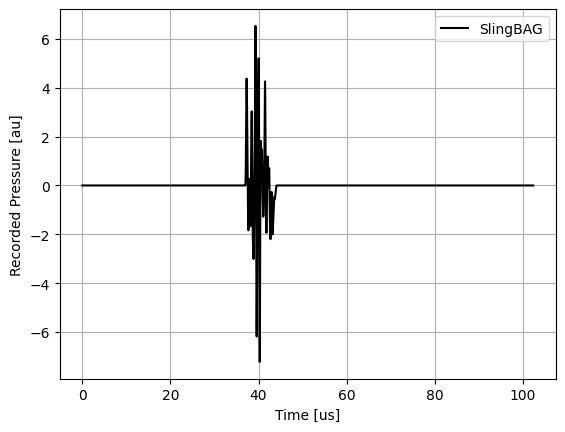

In [14]:
import matplotlib.pyplot as plt
sensor_data_matrix = np.loadtxt('simulated_sensor_signal.txt', delimiter='\t')
simulated_signal = sensor_data_matrix
num_times = 4096
Nt = num_times
_, ax1 = plt.subplots()
ax1.plot((np.arange(0, Nt))*25e-3, simulated_signal[10, :], "k-", label="SlingBAG") 
ax1.set(xlabel=f"Time [us]", ylabel="Recorded Pressure [au]") # 修正 here "Time]"
ax1.grid(True)
ax1.legend(loc="upper right")